# Dataset Generation

From https://www.mrlc.gov/data/nlcd-land-cover-conus-all-years

In [1]:
import geopandas
import random
from shapely.geometry import Point, Polygon, MultiPolygon
import rasterio
import matplotlib.pyplot as plt
import fiona.transform
from zipfile import ZipFile, ZIP_DEFLATED, ZIP_LZMA
import numpy as np
import io
import pandas as pd
import sqlite3

## Read State Shape file

In [2]:
city = {"madison":Point(-89.39,43.08),
        "milwaukee":Point(-87.97,43.06),
        "greenbay":Point(-87.99,44.52),
        "kenosha":Point(-87.87,42.59),
        "racine":Point(-87.81,42.73),
        "appleton":Point(-88.39,44.28),
        "waukesha":Point(-88.25,43.01),
        "oshkosh":Point(-88.56,44.02),
        "eauclaire":Point(-91.49,44.82),
        "janesville":Point(-89.01,42.69),
       }

In [3]:
cong = geopandas.read_file("zip://data/cb_2018_us_cd116_20m.zip")
wi = cong[cong["STATEFP"] == "55"]
wi.head(3)

,STATEFP,CD116FP,AFFGEOID,GEOID,LSAD,CDSESSN,ALAND,AWATER,geometry
89,55,06,5001600US5506,5506,C2,116,12740758652,7315844396,"POLYGON ((-89.78490 43.64105, -89.71873 43.643..."
92,55,04,5001600US5504,5504,C2,116,332617267,2454549243,"POLYGON ((-88.07030 43.12271, -88.07021 43.125..."
131,55,08,5001600US5508,5508,C2,116,17629673120,8180685289,"MULTIPOLYGON (((-86.93428 45.42115, -86.83575 ..."


In [4]:
sample_size_per_district = 250
points = []
for row in wi.itertuples():
    district, shape = row.CD116FP, row.geometry
    minx, miny, maxx, maxy = shape.bounds

    i = 0
    while i < sample_size_per_district:
        pt = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        if not shape.contains(pt):
            continue
        points.append({"lon": pt.x, "lat": pt.y, "district": "district " + district, "geometry": pt})
        i += 1
sample = geopandas.GeoDataFrame(points).sample(frac=1).reset_index(drop=True).set_crs(wi.crs)
sample.head(3)

,lon,lat,district,geometry
0,-91.865560,44.659307,district 03,POINT (-91.86556 44.65931)
1,-90.763029,42.723827,district 03,POINT (-90.76303 42.72383)
2,-89.458414,42.727092,district 02,POINT (-89.45841 42.72709)


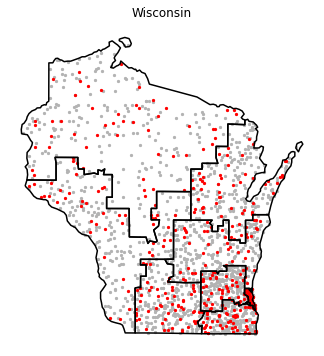

In [5]:
ax = wi.boundary.plot(color="black", figsize=(6,6))
sample.iloc[400:].plot(ax=ax, markersize=5, color="0.7")
sample.iloc[:400].plot(ax=ax, markersize=5, color="red")
plt.axis("off")
plt.title("Wisconsin")
plt.show()

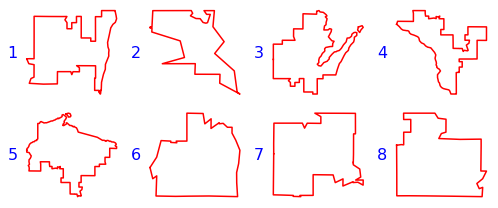

In [6]:
num_rows = 2
num_cols = 4

fig, ax_ll = plt.subplots(num_rows, num_cols, figsize=(7,3))

for i in range(num_rows):
    for j in range(num_cols):
        ax = ax_ll[i][j]
        polygon = wi.iloc[i * num_cols + j]["geometry"]

        # Some districts are Multipolygons
        if isinstance(polygon, MultiPolygon):
            for geom in polygon.geoms:
                x, y = geom.exterior.xy
                ax.plot(x, y, color="r")
        else:
            x, y = polygon.exterior.xy
            ax.plot(x, y, color="r")
            
        ax.axis("off")
        ax.text(-0.1, 0.5, i * num_cols + j + 1, size=16,
            verticalalignment="center", horizontalalignment="center",
            transform=ax.transAxes, color="b")
        
plt.tight_layout()
plt.savefig("imgs/congressional_districts.png", dpi=150)
plt.show()

## Extract area coded images corresponding to Points

In [7]:
# data: https://www.mrlc.gov/data/nlcd-land-cover-conus-all-years

import time

def get_map(raster, pt, radius):
    # raster coords to cell
    x,y = raster.index(pt.x, pt.y)
    return raster.read(window=((x-radius,x+radius),(y-radius,y+radius)))

t0 = time.time()

with ZipFile(f"data/images.zip", "w", compression=ZIP_LZMA) as zf:
    path = f"zip://NLCD_2016_Land_Cover_L48_20190424.zip!NLCD_2016_Land_Cover_L48_20190424.img"

    with rasterio.open(path) as raster:
        sample = sample.to_crs(raster.crs).copy()
        sample["file_name"] = None
        for i in sample.index:
            if i % 100 == 0:
                print(i, sample.at[i, "geometry"])
            radius = 50
            m = get_map(raster, sample.at[i, "geometry"], radius=radius)
            fname = f"area{str(i).zfill(4)}.npy"
            with zf.open(fname, "w") as img_file:
                np.save(img_file, m[0,:,:])
            sample.at[i, "file_name"] = fname

t1 = time.time()
print("SEC", t1-t0)

0 POINT (327105.962476361 2414910.890174292)
100 POINT (632340.0762095588 2223026.605768065)
200 POINT (630286.483522973 2256178.792125026)
300 POINT (563336.4522595651 2363274.687377475)
400 POINT (533168.5542205893 2186017.917316675)
500 POINT (563891.0911981357 2292922.545622513)
600 POINT (661200.2945540907 2202830.445416282)
700 POINT (653517.5326474149 2257234.978094934)
800 POINT (339754.1841943541 2385676.03532041)
900 POINT (636284.7870974055 2302725.398059933)
1000 POINT (427882.3585404383 2541299.242278273)
1100 POINT (369680.9468722682 2446710.622569941)
1200 POINT (607151.2385812985 2194204.476019527)
1300 POINT (667450.1957900372 2433877.84106834)
1400 POINT (655856.7531196004 2209626.275763736)
1500 POINT (593150.0128680925 2336463.903787098)
1600 POINT (503987.457613314 2192798.948485803)
1700 POINT (487448.4159134054 2210596.333034032)
1800 POINT (606629.3957022567 2327718.796649695)
1900 POINT (624546.2399116065 2224201.024513671)
SEC 78.76169323921204


In [8]:
sample

,lon,lat,district,geometry,file_name
0,-91.865560,44.659307,district 03,POINT (327105.962 2414910.890),area0000.npy
1,-90.763029,42.723827,district 03,POINT (426150.316 2203589.405),area0001.npy
2,-89.458414,42.727092,district 02,POINT (532135.182 2210531.481),area0002.npy
3,-88.081207,44.404922,district 08,POINT (628344.443 2405651.215),area0003.npy
4,-89.175562,43.200152,district 02,POINT (551313.716 2264862.020),area0004.npy
...,...,...,...,...,...
1995,-88.667894,44.033067,district 06,POINT (585082.999 2360588.884),area1995.npy
1996,-88.153575,42.606256,district 01,POINT (639172.138 2205105.899),area1996.npy
1997,-88.469034,43.419232,district 05,POINT (606340.462 2293557.158),area1997.npy
1998,-90.641210,46.426972,district 07,POINT (412811.437 2615864.633),area1998.npy


## Create images.db

In [9]:
district_tbl = pd.DataFrame([
    [103, "district 01"],
    [999, "district 02"],
    [321, "district 03"],
    [12, "district 04"],
    [321, "district 05"],
    [25, "district 06"],
    [1024, "district 07"],
    [500, "district 08"],
], columns=["district_id", "district_name"])

lookup = dict(district_tbl.set_index("district_name")["district_id"])
sample["district_id"] = sample["district"].apply(lambda name: lookup[name])
for col in ["water_ratio", "forest_ratio", "agriculture_ratio", "developed_ratio"]:
    sample[col] = None

In [10]:
sample.head(3)

,lon,lat,district,geometry,file_name,district_id,water_ratio,forest_ratio,agriculture_ratio,developed_ratio
0,-91.865560,44.659307,district 03,POINT (327105.962 2414910.890),area0000.npy,321,None,None,None,None
1,-90.763029,42.723827,district 03,POINT (426150.316 2203589.405),area0001.npy,321,None,None,None,None
2,-89.458414,42.727092,district 02,POINT (532135.182 2210531.481),area0002.npy,999,None,None,None,None


In [11]:
with sqlite3.connect(f"data/images.db") as c:
    district_tbl.to_sql("districts", c, index=False, if_exists="replace")
    tbl = sample[["file_name", "lon", "lat", "district_id", "water_ratio", "forest_ratio", "agriculture_ratio"]]
    tbl.to_sql("sample", c, index=False, if_exists="replace")

## Show sample area

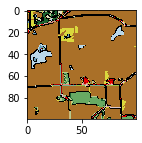

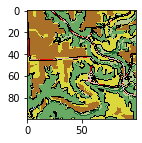

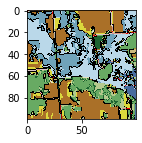

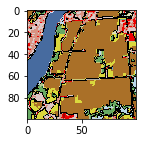

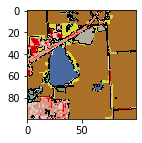

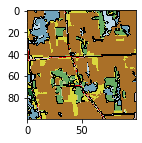

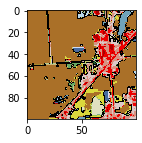

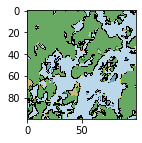

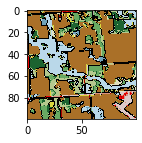

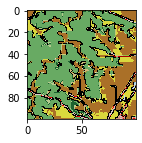

In [13]:
from matplotlib.colors import ListedColormap
use_cmap = np.zeros(shape=(256,4))
use_cmap[:,-1] = 1
uses = np.array([
    [0, 0.00000000000, 0.00000000000, 0.00000000000],
    [11, 0.27843137255, 0.41960784314, 0.62745098039],
    [12, 0.81960784314, 0.86666666667, 0.97647058824],
    [21, 0.86666666667, 0.78823529412, 0.78823529412],
    [22, 0.84705882353, 0.57647058824, 0.50980392157],
    [23, 0.92941176471, 0.00000000000, 0.00000000000],
    [24, 0.66666666667, 0.00000000000, 0.00000000000],
    [31, 0.69803921569, 0.67843137255, 0.63921568628],
    [41, 0.40784313726, 0.66666666667, 0.38823529412],
    [42, 0.10980392157, 0.38823529412, 0.18823529412],
    [43, 0.70980392157, 0.78823529412, 0.55686274510],
    [51, 0.64705882353, 0.54901960784, 0.18823529412],
    [52, 0.80000000000, 0.72941176471, 0.48627450980],
    [71, 0.88627450980, 0.88627450980, 0.75686274510],
    [72, 0.78823529412, 0.78823529412, 0.46666666667],
    [73, 0.60000000000, 0.75686274510, 0.27843137255],
    [74, 0.46666666667, 0.67843137255, 0.57647058824],
    [81, 0.85882352941, 0.84705882353, 0.23921568628],
    [82, 0.66666666667, 0.43921568628, 0.15686274510],
    [90, 0.72941176471, 0.84705882353, 0.91764705882],
    [95, 0.43921568628, 0.63921568628, 0.72941176471],
])
for row in uses:
    use_cmap[int(row[0]),:-1] = row[1:]
use_cmap = ListedColormap(use_cmap)

def show_img(name):
    plt.figure(figsize = (2,2))
    with ZipFile(f"data/images.zip") as zf:
        with zf.open(name) as f:
            buf = io.BytesIO(f.read())
            B = np.load(buf)
    plt.imshow(B, cmap=use_cmap, vmin=0, vmax=255)
    return B
for i in range(10):
    show_img(f"area{str(i).zfill(4)}.npy")